# Self-Driving Car Engineer Nanodegree

## Deep Learning Project: Traffic Sign Recognition Classifier

The goal of this project is to develop a deep neural network classifier for the German Traffic Sign Recognition Benchmark (GTSRB). 
The well known LeNet-5 network architecture will be used as a basis for this task.



## Load The Data Set

In [1]:
import pickle

# load the pickled data set
training_file = 'traffic-signs-data/train.p'
validation_file='traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)


## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set 

In [2]:
import numpy as np

# number of training examples
n_train = train['features'].shape[0]

# number of validation examples
n_valid = valid['features'].shape[0]

# number of testing examples
n_test = test['features'].shape[0]

# shape of a traffic sign image
image_shape = (test['features'].shape[1], test['features'].shape[2])

# number of unique classes/labels in the dataset
n_classes = len(np.unique(test['labels'])) 

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Exploratory visualization of the dataset

This section tries to give some intuition about the composition of the data set:
- How are the training examples spread out among classes?
- What are classes with a small / large number of training examples?
- How do some of the images in the training data look like?

<a id='num_examples_per_class'></a>

Maximum number of class examples: 2010
Minimum number of class examples: 180


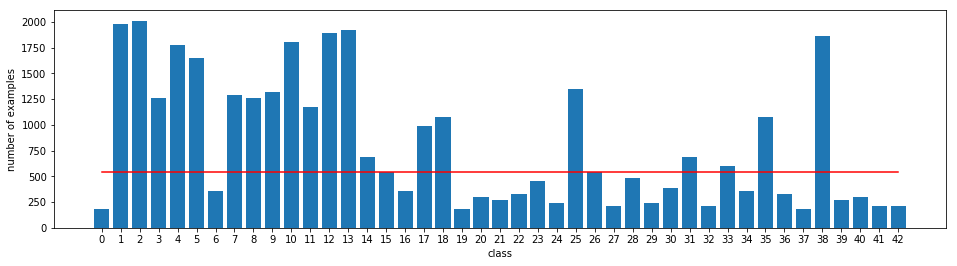

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

n, indices, counts = np.unique(train['labels'], return_index=True, return_counts=True) 

print("Maximum number of class examples: {}".format(np.max(counts)))
print("Minimum number of class examples: {}".format(np.min(counts)))

med = np.median(counts)

plt.figure(figsize = (16, 4))
plt.bar(train['labels'][indices], counts)
plt.xticks(train['labels'][indices], train['labels'][indices]);
plt.xlabel('class');
plt.ylabel('number of examples');

plt.plot([0, n_classes-1], [med, med], 'r');

The bar chart above shows the different numbers of training examples for each of the 43 classes. The red line illustrates the median number of examples per class. 

Let's explore some of the **rare classes** with only a small number of training examples:

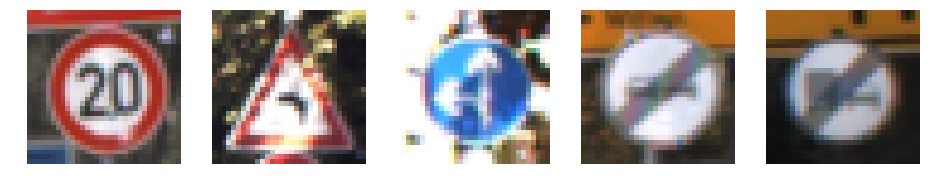

In [4]:
rare_classes = [0, 19, 37, 41, 42]

def plotClassExamples(classes, example_index=0):
    plt.figure(figsize = (16, 4))
    for i, n_class in enumerate(classes):
        plt.subplot(1, len(rare_classes), i+1)
        class_indices = np.argwhere(train['labels'] == n_class)[:,0]
        plt.imshow(train['features'][class_indices[example_index]])
        plt.axis('off');
        
plotClassExamples(rare_classes, example_index=140)

In contrast, here are some images from **prominent classes** with a large number of training examples:

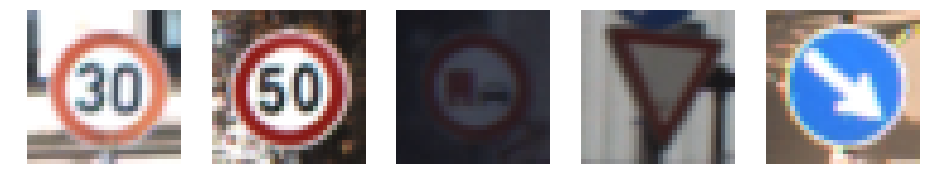

In [5]:
prominent_classes = [1, 2, 10, 13, 38]

plotClassExamples(prominent_classes, example_index=80)

----

## Design and Test of the Model Architecture


### Pre-process the Data Set

To improve the performance of the neural network, some preprocessing is applied to the traffic sign images.

[This paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) by Pierre Sermanet and Yann LeCun suggests that grayscaling the images improves classification accuracy on the GTSRB data set. 
The following grayscale function is therefore used to merge color channels according to the YUV color space definition:

In [6]:
def grayscale(rgb):
    
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b    

    return gray

The normalize function maps pixel intensity values to the interval [-1, 1]. This is done in order to speed up convergence during the optimization process. 

In [7]:
def normalize(img):    
    
    max_val = np.max(img)
    min_val = np.min(img)
    
    return (img - min_val)*2.0/(max_val - min_val) - 1.0

Gray scaling and normalization is applied to the whole set of training, validation and test data:

In [8]:
def preprocessImages(images):
    n_images = images.shape[0]
    
    X = np.zeros((n_images, 32, 32, 1))
    
    for i in range(n_images):
        img = normalize(grayscale(images[i]))
        img.shape = (32, 32, 1)
        X[i] = img
    
    return X

y_train      = train['labels']
y_validation = valid['labels']
y_test       = test['labels']

X_train      = preprocessImages(train['features'])
X_validation = preprocessImages(valid['features'])
X_test       = preprocessImages(test['features'])

### Generate fake Data

As can be seen in the [bar chart above](#num_examples_per_class), some classes have a lot less training examples than others. 
While training the network, these classes would therefore occur less often, have less influence on the loss function and as a result would probably be predicted with less accuracy after training has finished. 

In order to improve classification for these rare classes, their number of training examples gets artificially increased by copying existing examples:

In [9]:
n, indices, counts = np.unique(train['labels'], return_index=True, return_counts=True)

med = np.median(counts)

X_train_fake = np.copy(X_train)
y_train_fake = np.copy(y_train)

for i in range(n_classes):
    class_label = train['labels'][indices[i]]
    num_examples = counts[i]    
    
    # if the number of examples is small, duplicate all examples of this class 
    if num_examples < med:
        
        X_train_fake = np.append(X_train_fake, X_train[y_train == class_label], axis=0)
        X_train_fake = np.append(X_train_fake, X_train[y_train == class_label], axis=0)
        
        y_train_fake = np.append(y_train_fake, y_train[y_train == class_label], axis=0)
        y_train_fake = np.append(y_train_fake, y_train[y_train == class_label], axis=0)


X_train = X_train_fake    
y_train = y_train_fake 

n_train = y_train.shape[0]

### Model Architecture

The LeNet-5 architecture will be the basis for classifying traffic sign images.
It consists of two convolutional layers followed by three fully connected layers.

TODO customization

To capture more detail from the training data the LeNet architecture gets extended. 
The convolution layers are now deeper and dropout has been added to the fully connected layers.

In [10]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

def ExtendedLeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # changed 28x28x6 to 28x28x10
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x10.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 10), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(10))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x8. Output = 14x14x8.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # changed 10x10x16 to 10x10x20
    # Layer 2: Convolutional. Output = 10x10x20.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 10, 20), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(20))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x20. Output = 5x5x20.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x20. Output = 500.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 500. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(500, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob) # added dropout   

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob) # added dropout
    
    # ----------------------------------------
    # added another fully connected layer 
    
    # Layer 5: Fully Connected. Input = 84. Output = 60.
    fc21_W  = tf.Variable(tf.truncated_normal(shape=(84, 60), mean = mu, stddev = sigma))
    fc21_b  = tf.Variable(tf.zeros(60))
    fc21    = tf.matmul(fc2, fc21_W) + fc21_b

    # Activation.
    fc21    = tf.nn.relu(fc21)
    fc21    = tf.nn.dropout(fc21, keep_prob) # added dropout
    
    #------------------------------------------

    # Layer 6: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(60, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc21, fc3_W) + fc3_b

    return logits, conv1, conv2




### Train, Validate and Test the Model

A validation set is used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [11]:

rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

logits, conv1, conv2 = ExtendedLeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Training

In [16]:
EPOCHS = 20
BATCH_SIZE = 128

perform_training = False

if perform_training:

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, './lenet')
        print("Model saved")

## Test on Test Data Set 
 

In [17]:
with tf.Session() as sess:

    saver.restore(sess, './lenet')
    #sess.run(tf.global_variables_initializer())

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.935


## Test Model on New Images

In this section the model is used to predict the sign type of new images from the web. These new images have been manually cropped to a quadratic shape containing the traffic sign.

### Load and Output the Images

The following figure shows the new test images from the web. Images in the top row are displayed in their native resolution while images in the bottom row have been downsampled to 32x32 to match the input size of the neural network.

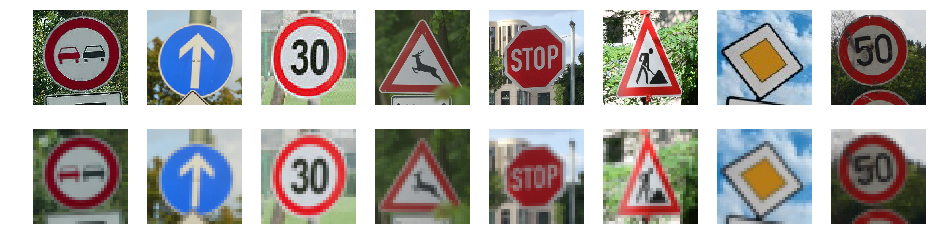

In [22]:
import matplotlib.image as mpimg
from scipy.misc import imresize

num_images = 8

images = []
images_hr = []

for n in range(num_images):
    img_hr = mpimg.imread('./traffic_signs/{}.jpg'.format(n+1))
    images_hr.append(img_hr)
    images.append(imresize(img_hr, (32,32)))

plt.figure(figsize = (16, 4))

for i in range(num_images):
    plt.subplot(2,num_images,i+1)
    plt.imshow(images_hr[i])
    plt.axis('off')
    
    plt.subplot(2,num_images,num_images+i+1)
    plt.imshow(images[i])
    plt.axis('off')


In [23]:
# manually set the right classes for each image
class_labels = [9, 35, 1, 31, 14, 25, 12, 2]

### Predict the Sign Type for Each Image

In [24]:
images_processed = []

for i in range(num_images):
    images_processed.append(normalize(grayscale(images[i])))
    


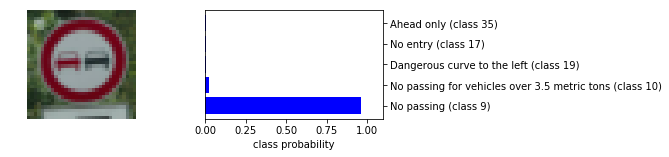

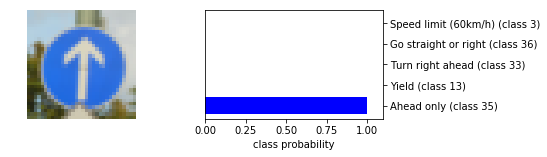

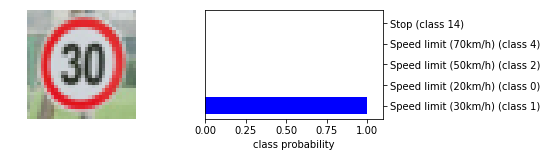

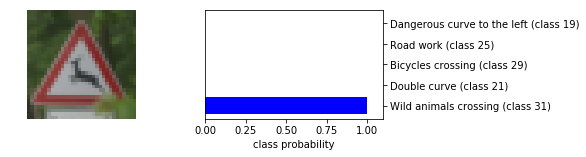

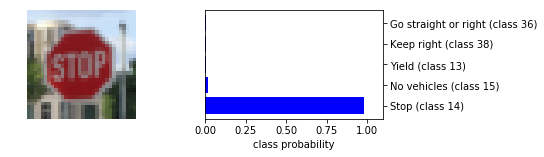

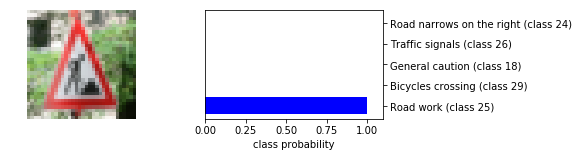

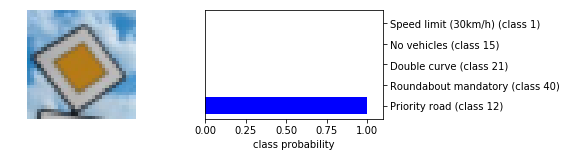

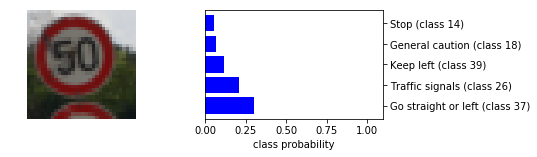

In [25]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))


def visualizePrediction(img, orig_img, sess):
    img.shape = (1,32,32,1)

    result = sess.run(logits,feed_dict={x: img, keep_prob: 1.0})
    result.shape = (result.shape[1]) 

    probs = softmax(result)

    probs_sort_indices = np.argsort(probs)[::-1]
    top_classes = probs_sort_indices[0:5]

    class_labels_predicted[i] = top_classes[0] #best prediction


    plt.figure(figsize = (7, 2))    
    
    plt.subplot(1,2,1)
    plt.imshow(orig_img)       
    plt.axis('off')            

    plt.subplot(1,2,2)
    plt.barh(range(5), probs[top_classes], color="blue")
    labels = []
    for c in top_classes:  
        labels.append('{} (class {})'.format(class_dict[str(c)], c))                                    

    plt.yticks(range(5), labels)
    #plt.ylabel('class')
    plt.xlabel('class probability')
    plt.xlim([0, 1.1]) 
    plt.gca().yaxis.tick_right()



import csv

# read the names of the classes into a dictionary
with open('./signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    class_dict = {rows[0]:rows[1] for rows in reader}
    

class_labels_predicted = np.zeros(num_images)

sess = tf.Session()
saver.restore(sess, './lenet')
    
for i in range(8):
    img = images_processed[i]
        
    visualizePrediction(img, images[i], sess)
        
               

### Performance Analysis

In [26]:
accuracy = 1.0 - len(np.nonzero(class_labels - class_labels_predicted))/num_images

print("Accuracy on test images = {:.3f}".format(accuracy))

Accuracy on test images = 0.875


The model managed to predict the correct class labels for 7 out of the 8 images from the web. 

In the case of the single false prediction (last image) the right class is not even contained in the top 5 predictions. This might have to do with the fact that the traffic sign is slightly at an angle. Let's try it again after manually correcting the orientation of the image:

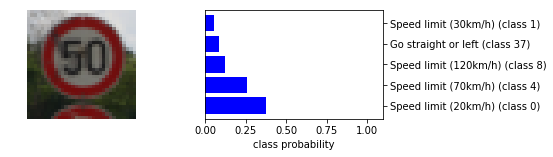

In [27]:
def predictImage(path, sess):
    img_orig = mpimg.imread(path)
    img = imresize(img_orig, (32,32))
    img_processed = normalize(grayscale(img))
    
    visualizePrediction(img_processed, img, sess)


predictImage('./traffic_signs/8_rot.jpg', sess)

Even though the correct label (class 2) is now inside the top 5 predictions (in 5th place), it is still far from the most probable prediction. 
This result is all the more surprising as class 2 has a comparatively high number of training examples. 
Other factors (e.g. the dirt in the traffic sign) seem to still fool the network into thinking the image shows a "70" instead of a "50". 



### Behavior on unrelated Images

After evaluating the network performance on traffic sign images it should be interesting to see what the network thinks of images that are completely unrelated to traffic signs:

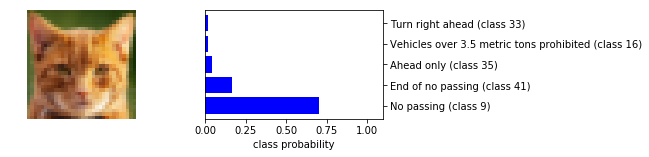

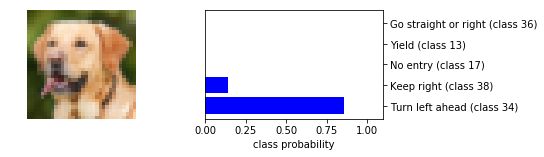

In [28]:
predictImage('./cat.jpg', sess) 
predictImage('./dog.jpg', sess)  

Although the network has never seen a dog or a cat before, their respective images cause the network to predict one class with significantly higher probability than other classes. 

We trained the neural network to classify images into 43 classes. The network therefore believes that each and every image that we feed into it belongs to one of those classes. 
Now when we feed it a new random image that does not belong to any of those classes, the network will still try to classify this image based on the 43 given output classes.
As the probability mass has to be placed somewhere (the class probabilities need to sum up to 1.0), it gets placed on classes for which the image contains some features of and where features of other classes are mostly absent.


---

## Visualize the Neural Network's State

In this section we will take a look at the activations of the feature maps inside the neural network for a given image.
This helps to show what characteristics of an image the network finds interesting.

In [30]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

sess = tf.Session()
saver.restore(sess, './lenet')   

def outputFeatureMap(image_path, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    img_orig = mpimg.imread(image_path)
    img = imresize(img_orig, (32,32))
    image_input = normalize(grayscale(img))
    image_input.shape = (1,32,32,1)
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob : 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")


Let's take a look at the activations of one of the test images from the last section:

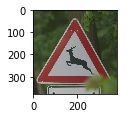

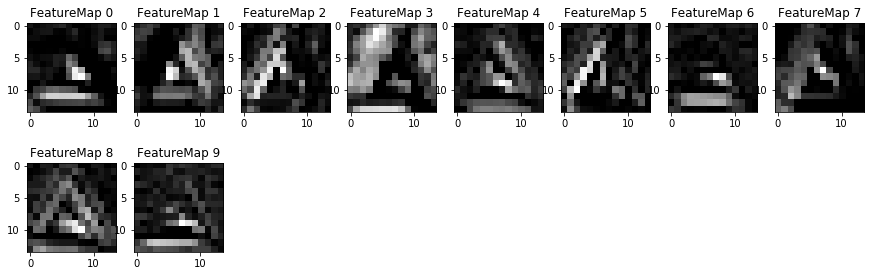

In [31]:
plt.figure(figsize = (1.5, 2))
plt.imshow(mpimg.imread('./traffic_signs/4.jpg'));

outputFeatureMap('./traffic_signs/4.jpg', conv1, plt_num=2)

The plots above clearly indicate that the first convolutional layer of the network places high avtivations on interesting features of the input image. 
The outline of the triangular shape is especially emphasized in the feature maps 0, 1, 5 and 6. 
Feature maps 0,6 and 7 also show how the shape of the animal depicted on the traffic sign leads to high activations.

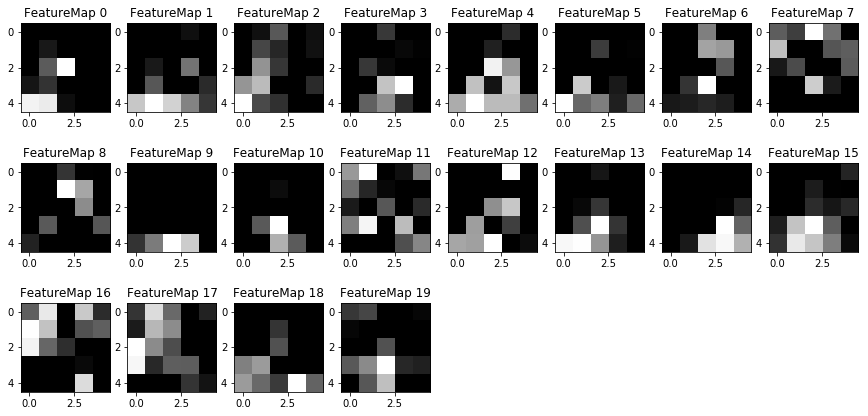

In [32]:
outputFeatureMap('./traffic_signs/4.jpg', conv2, plt_num=2)

The second convolutional layer already appears much more abstract in the sense that we cannot really visually compare the feature maps to the original input image anymore.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.